In [2]:
import os
import pandas as pd
import numpy as np
# ! pip install supervenn
# from supervenn import supervenn

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from utils_neptune import get_latest_dataset
import pickle

2024-07-16 19:04:02.308364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 19:04:02.364254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 19:04:02.364308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 19:04:02.385755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='
project_id = 'revivemed/RCC'
homedir = os.path.expanduser("~")
input_data_dir = f'{homedir}/INPUT_DATA'
os.makedirs(input_data_dir, exist_ok=True)
input_data_dir = get_latest_dataset(data_dir=input_data_dir,api_token=NEPTUNE_API_TOKEN,project=project_id)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/metadata


In [123]:
savefig_params = {'dpi': 300, 'bbox_inches': 'tight', 'pad_inches': 0.05}
# %% [markdown]
# ## Key Peaks

# %%
savefig_params = {'dpi': 300, 'bbox_inches': 'tight', 'pad_inches': 0.05}

In [6]:

def get_color_map(n):

    my_32_colors = plt.cm.Accent.colors + plt.cm.Dark2.colors + plt.cm.Set2.colors + plt.cm.Pastel2.colors
    my_10_colors = plt.cm.tab10.colors
    my_20_colors = plt.cm.tab20.colors 
    my_42_colors = my_10_colors + my_32_colors
    my_52_colors = my_20_colors + my_32_colors

    if n <= 10:
        return my_10_colors
    elif n <= 20:
        return my_20_colors
    elif n <= 32:
        return my_32_colors
    elif n <= 42:
        return my_42_colors
    elif n <= 52:
        return my_52_colors
    else:
        # create a colormap from turbo
        return plt.cm.turbo(np.linspace(0, 1, n))
    
def assign_color_map(unique_vals):
    my_colors = get_color_map(len(unique_vals))
    color_map = dict(zip(np.sort(unique_vals), my_colors))
    return color_map


def create_plot(plot_df, hue_col, palette_dict,include_MV=True,sz=None):
    if 'UMAP1' in plot_df.columns:
        x_col = 'UMAP1'
        y_col = 'UMAP2'
    else:
        x_col = 'PC1'
        y_col = 'PC2'

    if sz is None:
        sz = 10/np.log2(plot_df.shape[0])
        print('marker size: ', sz)

    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=plot_df, x=x_col, y=y_col, hue=hue_col, palette=palette_dict, ax=ax, s=sz)
    
        # place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # edit the legend to include the number of samples in each cohort
    handles, labels = ax.get_legend_handles_labels()
    if include_MV:
        labels = [f'{label} (N={plot_df[plot_df[hue_col]==label].shape[0]}, MV%={plot_df[plot_df[hue_col]==label]["MV"].mean():.0f})' for label in labels]
    else:
        labels = [f'{label} (N={plot_df[plot_df[hue_col]==label].shape[0]})' for label in labels]

    # make the size of the markers in the handles larger
    for handle in handles:
        # print(dir(handle))
        handle.set_markersize(10)
        # handle._sizes = [100]
    
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return fig, ax

In [21]:
metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)
selections_df = pd.read_csv(f'{input_data_dir}/selection_df.csv',index_col=0)
metadata_df['Set'] = selections_df['Set']
# remove the skip data
metadata_df = metadata_df[metadata_df['Set']!='skip'].copy()
# remove the nan values in Study ID
# metadata_df = metadata_df[metadata_df['Study ID'].notnull()].copy()

/var/tmp/ipykernel_1490179/3895249970.py:1: DtypeWarning: Columns (1,28,30,31,32,33,34,46,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)


Some samples (N=279) do not have any Study ID. As of July 16th, Jonah is unsure why this is. another round of metadata cleaning is probably needed to resolve this. When loading the data for training, these samples have been ignored since they have no Study ID in the metadata. We can easily figure out which Study Id they belong to based on the directory that they reside

In [23]:
metadata_df[metadata_df['Study ID'].isnull()]

,Matt Set Label,Previous run_order,Previous MV,Study ID,is Pediatric,Cohort Label v0,Job ID,Cancer Risk,Column,Polarity,...,PFS_Event,ORR,Benefit,Clinical Trial Phase,Diagnosis Details,Emphysema/COPD,IMDC,MSKCC,Prior_2,Benzene_Exposure_Category
HILIC-pos-B1_MixAA_Mix.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HILIC-pos-B1_MixOrgAcids_MixOthers.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HILIC-pos-B1_Mix1.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HILIC-pos-B1_Mix2.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HILIC-pos-B1_QC_dln2.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101020_2x_Batch_4_C.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101020_2x_Batch_4_B.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21732E_1x_Batch_14_B.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21732E_1x_Batch_14_A.mzML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
metadata_df['Set'].value_counts()

Set
Pretrain Discovery Train    16862
Pretrain Test                2060
Pretrain Discovery Val       1905
Finetune Discovery Train      443
Finetune Discovery Val        149
Finetune Test                 149
Name: count, dtype: int64

## Remove the samples with Nan Study IDs

In [25]:
metadata_df = metadata_df[metadata_df['Study ID'].notnull()].copy()
metadata_df['Set'].value_counts()

Set
Pretrain Discovery Train    16636
Pretrain Test                2032
Pretrain Discovery Val       1880
Finetune Discovery Train      443
Finetune Discovery Val        149
Finetune Test                 149
Name: count, dtype: int64

In [45]:
subdir_col = 'Study ID'
subdir_list = metadata_df[subdir_col].unique()
# remove the nan values
subdir_list = subdir_list[~pd.isnull(subdir_list)]
print(subdir_list)

['ST001931' 'ST002112' 'ST002773' 'ST000422' 'stanford-hmp2' 'ST001422'
 'ST000909' 'ST001423' 'ST001408' 'ST002027' 'ST001519' 'ST001932'
 'ST001428' 'ST001849' 'ST002251' 'ST001236' 'ST000388' 'ST001237'
 'ST002244' 'ST002331' 'ST001918' 'ST000601']


In [111]:
study_id_to_label = metadata_df.groupby('Study ID')['Cohort Label v0'].first().to_dict()

cohort_label_to_color = assign_color_map(metadata_df['Cohort Label v0'].unique())
study_id_to_color = {k:cohort_label_to_color[v] for k,v in study_id_to_label.items()}

study_id_to_uniq_color = assign_color_map(np.sort(metadata_df['Study ID'].unique()))

# %%
color_dct = {
    'cohort_label_to_color': cohort_label_to_color,
    'study_id_to_color': study_id_to_color,
    'study_id_to_uniq_color': study_id_to_uniq_color,
}

## Next step

In [98]:
group_sz_dict = {}
freq_of_peaks_by_study = {}


for subdir in subdir_list:
    nan_file = f'{input_data_dir}/{subdir}/nan_matrix.csv'
    samples_in_cohort = metadata_df[metadata_df[subdir_col]==subdir].index
    nan_matrix = pd.read_csv(nan_file, index_col=0)
    nan_matrix = nan_matrix.loc[samples_in_cohort,:].copy()
    num_samples = nan_matrix.shape[0]
    
    freq_of_peaks = 1 - nan_matrix.mean(axis=0)
    freq_of_samples = 1 - nan_matrix.mean(axis=1)
    
    group_sz_dict[subdir] = num_samples
    freq_of_peaks_by_study[subdir] = freq_of_peaks

    # break

group_sz_df = pd.DataFrame(group_sz_dict, index=['N']).T
group_sz_df = group_sz_df.astype(int)
group_freq_df = pd.DataFrame(freq_of_peaks_by_study)

group_log_sz_df = np.log(1 + group_sz_df)
peak_robustness = group_freq_df.mul(group_log_sz_df['N'], axis=1).sum(axis=1)/group_log_sz_df['N'].sum()

In [110]:
group_peak_counts = {}
for study_id in subdir_list:
    group_peak_counts[study_id] = np.sum(group_freq_df[study_id] > 0) 

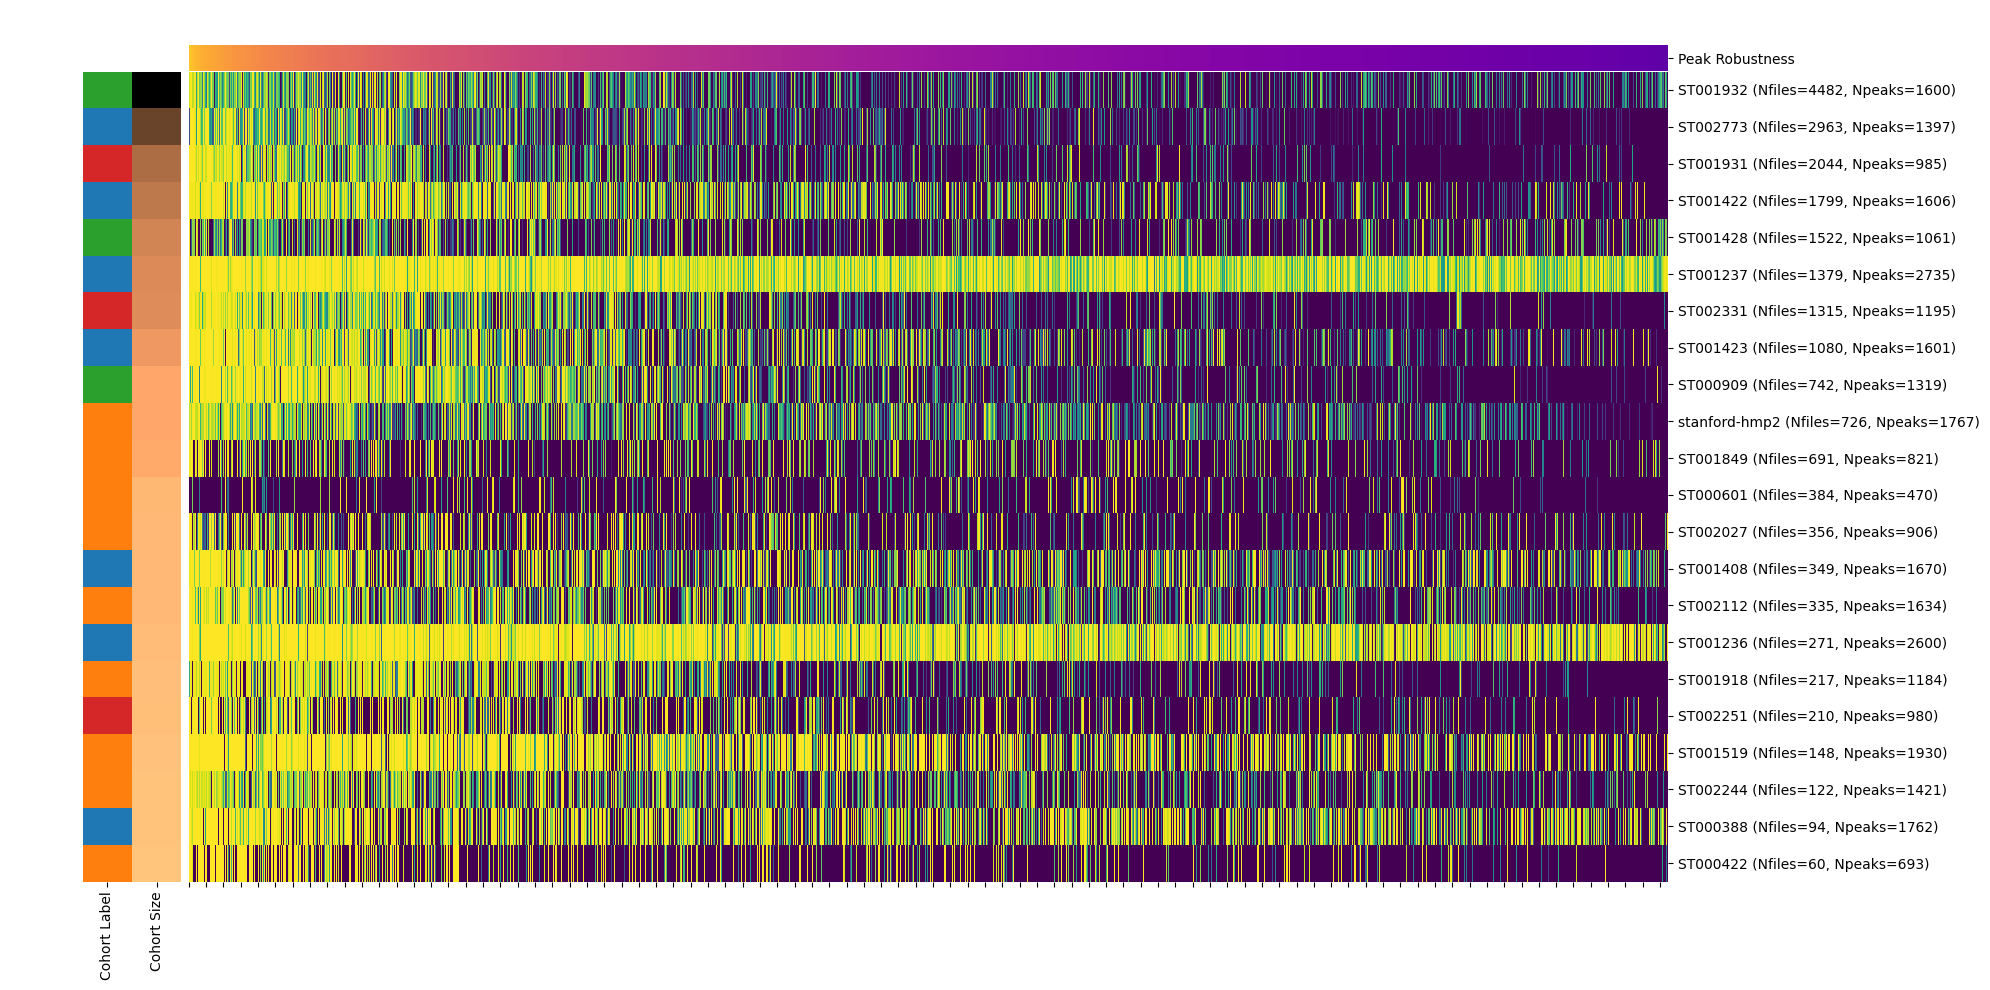

In [124]:
feat_info_3 = group_freq_df
# %%
col_cluster = False
row_cluster = False

plot_df = feat_info_3[subdir_list].T

col_colors = pd.DataFrame(index=plot_df.columns)
for col in feat_info_3.columns:
    if col in subdir_list:
        continue
    col_colors[col] = feat_info_3[col].map({True: 'black', False: 'white'})

col_colors[f'Peak Robustness'] = peak_robustness.map(lambda x: plt.cm.plasma(x))
# col_colors[f'Pass Threshold ({peak_robust_th})'] = (peak_robustness_dct[peak_robust_name] > peak_robust_th).map({True: 'black', False: 'white'})

####

if col_cluster==False:
    col_val_order = peak_robustness
    col_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df[col_val_order.index]

if row_cluster==False:
    row_val_order = group_sz_df['N'].copy()
    row_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df.loc[row_val_order.index]


row_colors = pd.DataFrame(index=plot_df.index)
row_colors['Cohort Label'] = [study_id_to_color[c] for c in plot_df.index]
row_colors['Cohort Size'] = [group_sz_df.loc[c, 'N'] for c in plot_df.index]
row_colors['Cohort Size'] = row_colors['Cohort Size']/row_colors['Cohort Size'].max()
row_colors['Cohort Size'] = row_colors['Cohort Size'].map(lambda x: plt.cm.copper_r(x))



# new_row_names = [f'{c} (Nfiles={group_sz_df.loc[c].values[0]}, Npeaks={align_counts[c]:.0f}, Align%={cohort_id_to_align_score[c]:.2f})' 
#         for c in plot_df.index]

new_row_names = [f'{c} (Nfiles={group_sz_df.loc[c].values[0]}, Npeaks={group_peak_counts[c]:.0f})' 
        for c in plot_df.index]



plot_df.index =  new_row_names
row_colors.index = new_row_names

g = sns.clustermap(plot_df, cmap='viridis', figsize=(20,10), 
            row_colors=row_colors, col_colors=col_colors, 
            col_cluster=col_cluster, row_cluster=row_cluster,
            dendrogram_ratio=0.04)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
# add a label to the colorbar 
g.cax.set_ylabel('Peak Frequency')
# remove the colorbar
g.cax.set_visible(False)